# Практическая работа (PY-HW-1)

# Задача

Один из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение.

Задача заключается в том, чтобы предложить алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.


Для решения этой задачи загрузите файлы из базы в Postgres.
Эта БД хранит информацию о клиентах банка и их персональные данные, такие как пол, количество детей и другие.

Описание таблиц с данными представлено ниже.


**D_work**

Описание статусов относительно работы:
- ID — идентификатор социального статуса клиента относительно работы;
- COMMENT — расшифровка статуса.


**D_pens**

Описание статусов относительно пенсии:
- ID — идентификатор социального статуса;
- COMMENT — расшифровка статуса.


**D_clients**

Описание данных клиентов:
- ID — идентификатор записи;
- AGE	— возраст клиента;
- GENDER — пол клиента (1 — мужчина, 0 — женщина);
- EDUCATION — образование;
- MARITAL_STATUS — семейное положение;
- CHILD_TOTAL	— количество детей клиента;
- DEPENDANTS — количество иждивенцев клиента;
- SOCSTATUS_WORK_FL	— социальный статус клиента относительно работы (1 — работает, 0 — не работает);
- SOCSTATUS_PENS_FL	— социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);
- REG_ADDRESS_PROVINCE — область регистрации клиента;
- FACT_ADDRESS_PROVINCE — область фактического пребывания клиента;
- POSTAL_ADDRESS_PROVINCE — почтовый адрес области;
- FL_PRESENCE_FL — наличие в собственности квартиры (1 — есть, 0 — нет);
- OWN_AUTO — количество автомобилей в собственности.


**D_agreement**

Таблица с зафиксированными откликами клиентов на предложения банка:
- AGREEMENT_RK — уникальный идентификатор объекта в выборке;
- ID_CLIENT — идентификатор клиента;
- TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было).
    
    
**D_job**

Описание информации о работе клиентов:
- GEN_INDUSTRY — отрасль работы клиента;
- GEN_TITLE — должность;
- JOB_DIR — направление деятельности внутри компании;
- WORK_TIME — время работы на текущем месте (в месяцах);
- ID_CLIENT — идентификатор клиента.


**D_salary**

Описание информации о заработной плате клиентов:
- ID_CLIENT — идентификатор клиента;
- FAMILY_INCOME — семейный доход (несколько категорий);
- PERSONAL_INCOME — личный доход клиента (в рублях).


**D_last_credit**

Информация о последнем займе клиента:
- ID_CLIENT — идентификатор клиента;
- CREDIT — сумма последнего кредита клиента (в рублях);
- TERM — срок кредита;
- FST_PAYMENT — первоначальный взнос (в рублях).


**D_loan**

Информация о кредитной истории клиента:
- ID_CLIENT — идентификатор клиента;
- ID_LOAN — идентификатор кредита.

**D_close_loan**

Информация о статусах кредита (ссуд):
- ID_LOAN — идентификатор кредита;
- CLOSED_FL — текущий статус кредита (1 — закрыт, 0 — не закрыт).

Будьте внимательны при сборке датасета: это реальные банковские данные, в которых могут наблюдаться дубли, некорректно заполненные значения или значения, противоречащие друг другу. Для получения качественной модели необходимо предварительно очистить датасет от такой информации.

## Импорт библиотек, константы

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import duckdb as db
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [15]:
RANDOM_STATE = 42

## Задание 1

Соберите всю информацию о клиентах в одну таблицу, где одна строчка соответствует полной информации об одном клиенте.

### Загрузка и обзор данных

In [16]:
D_agreement = pd.read_csv("datasets\D_agreement.csv")
D_clients = pd.read_csv("datasets\D_clients.csv")
D_close_loan = pd.read_csv("datasets\D_close_loan.csv")
D_job = pd.read_csv("datasets\D_job.csv")
D_last_credit = pd.read_csv("datasets\D_last_credit.csv")
D_loan = pd.read_csv("datasets\D_loan.csv")
D_pens = pd.read_csv("datasets\D_pens.csv")
D_salary = pd.read_csv("datasets\D_salary.csv")
D_work = pd.read_csv("datasets\D_work.csv")

In [17]:
D_client_loan = db.sql("SELECT l.ID_CLIENT, COUNT(l.ID_LOAN) as LOAN_NUM_TOTAL, SUM(cl.CLOSED_FL) as LOAN_NUM_CLOSED "
                       + " FROM D_loan l "
                       + " left join D_close_loan cl on l.ID_LOAN = cl.ID_LOAN "
                       + " GROUP BY l.ID_CLIENT"
                       + " HAVING COUNT(l.ID_LOAN) > 1"
                       ).fetchdf()

In [18]:
df = db.sql("SELECT a.TARGET, c.ID as ID_CLIENT, a.AGREEMENT_RK, c.AGE, c.SOCSTATUS_WORK_FL, c.SOCSTATUS_PENS_FL, c.GENDER, c.CHILD_TOTAL, c.DEPENDANTS, "
            + " s.PERSONAL_INCOME, cl.LOAN_NUM_TOTAL, cl.LOAN_NUM_CLOSED "
            + " FROM D_agreement a " 
            + " left join D_clients c on a.ID_CLIENT = c.ID " 
            + " left join D_salary s on s.ID_CLIENT = c.ID " 
            + " left join D_last_credit lc on lc.ID_CLIENT = c.ID " 
            + " left join D_client_loan cl on cl.ID_CLIENT = c.ID "
            ).fetchdf()

### Описание данных

**Целевая переменная**  

    - TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было);

**Признаки**    

    - AGREEMENT_RK — уникальный идентификатор объекта в выборке;
    - AGE — возраст клиента;
    - SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает);
    - SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер);
    - GENDER — пол клиента (1 — мужчина, 0 — женщина);
    - CHILD_TOTAL — количество детей клиента;
    - DEPENDANTS — количество иждивенцев клиента;
    - PERSONAL_INCOME — личный доход клиента (в рублях);
    - LOAN_NUM_TOTAL — количество ссуд клиента;
    - LOAN_NUM_CLOSED — количество погашенных ссуд клиента.

### Оценка качества данных

#### Выбросы

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15523 entries, 0 to 15522
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TARGET             15523 non-null  int64  
 1   ID_CLIENT          15523 non-null  int64  
 2   AGREEMENT_RK       15523 non-null  int64  
 3   AGE                15523 non-null  int64  
 4   SOCSTATUS_WORK_FL  15523 non-null  int64  
 5   SOCSTATUS_PENS_FL  15523 non-null  int64  
 6   GENDER             15523 non-null  int64  
 7   CHILD_TOTAL        15523 non-null  int64  
 8   DEPENDANTS         15523 non-null  int64  
 9   PERSONAL_INCOME    15523 non-null  float64
 10  LOAN_NUM_TOTAL     4005 non-null   float64
 11  LOAN_NUM_CLOSED    4005 non-null   float64
dtypes: float64(3), int64(9)
memory usage: 1.4 MB


In [20]:
df.describe()

,TARGET,ID_CLIENT,AGREEMENT_RK,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED
count,15523.000000,1.552300e+04,1.552300e+04,15523.000000,15523.000000,15523.000000,15523.000000,15523.000000,15523.000000,15523.000000,4005.000000,4005.000000
mean,0.119371,1.068120e+08,6.539832e+07,40.400438,0.909360,0.134639,0.653997,1.098886,0.644850,13848.041638,2.501124,1.982772
std,0.324235,4.395857e+03,4.569483e+06,11.607242,0.287105,0.341348,0.475709,0.996748,0.812663,8998.618992,0.879226,1.058694
min,0.000000,1.068044e+08,5.991015e+07,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,2.000000,0.000000
25%,0.000000,1.068082e+08,6.191984e+07,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8000.000000,2.000000,1.000000
50%,0.000000,1.068120e+08,6.436952e+07,39.000000,1.000000,0.000000,1.000000,1.000000,0.000000,12000.000000,2.000000,2.000000
75%,0.000000,1.068158e+08,6.708832e+07,50.000000,1.000000,0.000000,1.000000,2.000000,1.000000,17000.000000,3.000000,2.000000
max,1.000000,1.068196e+08,7.529224e+07,67.000000,1.000000,1.000000,1.000000,10.000000,7.000000,250000.000000,11.000000,11.000000


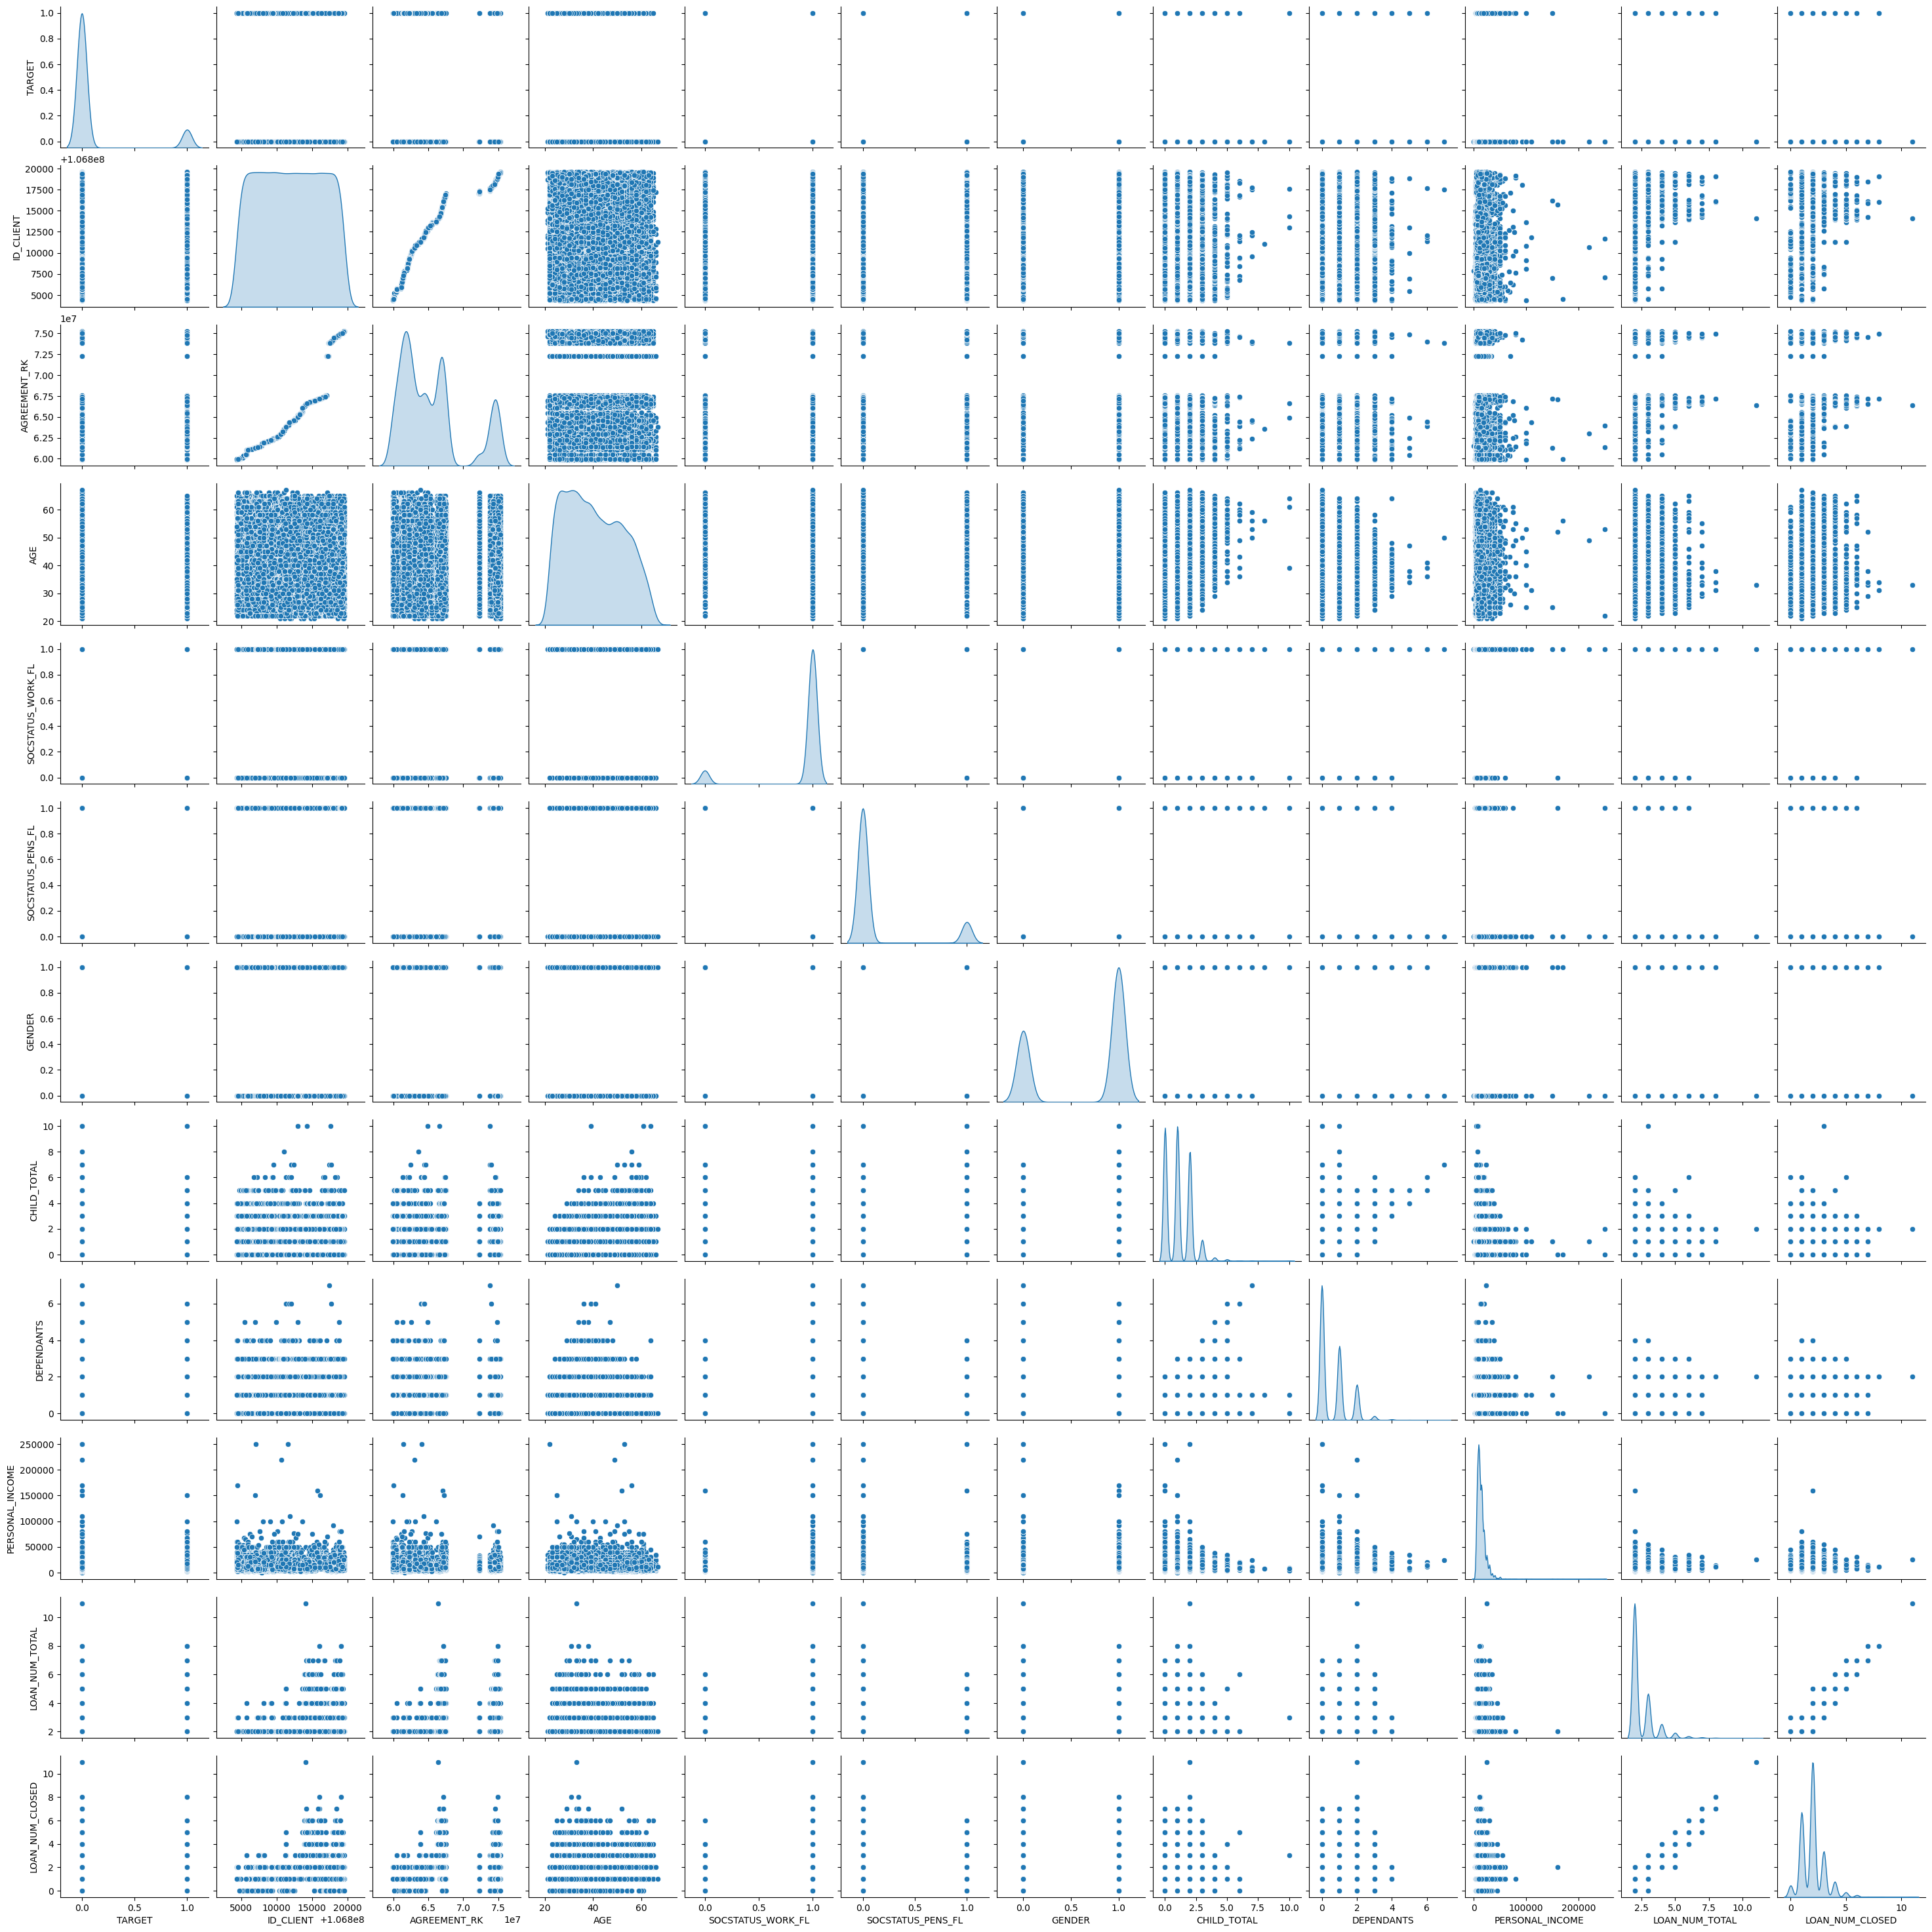

In [21]:
g = sns.pairplot(df, diag_kind="kde")

In [22]:
# Возраст
import plotly.express as px

fig = px.histogram(df["AGE"])
fig.show()

In [23]:
# социальный статус 
import plotly as py
import plotly.graph_objs as go

pyplt = py.offline.plot
labels = ['не работает', 'работает']
values = [df['SOCSTATUS_WORK_FL'][(df['SOCSTATUS_WORK_FL'] == 0)].count(),
          df['SOCSTATUS_WORK_FL'][(df['SOCSTATUS_WORK_FL'] > 0)].count()]

trace = [go.Pie(labels=labels, values=values)]
layout = go.Layout(
    title='Cоциальный статус клиента относительно работы'
)
fig = go.Figure(data=trace,layout=layout)
fig.show()

#### Дубли и пропуски

In [24]:
duplicateRows = df[df.duplicated()]

#### Корреляция признаков

<Axes: >

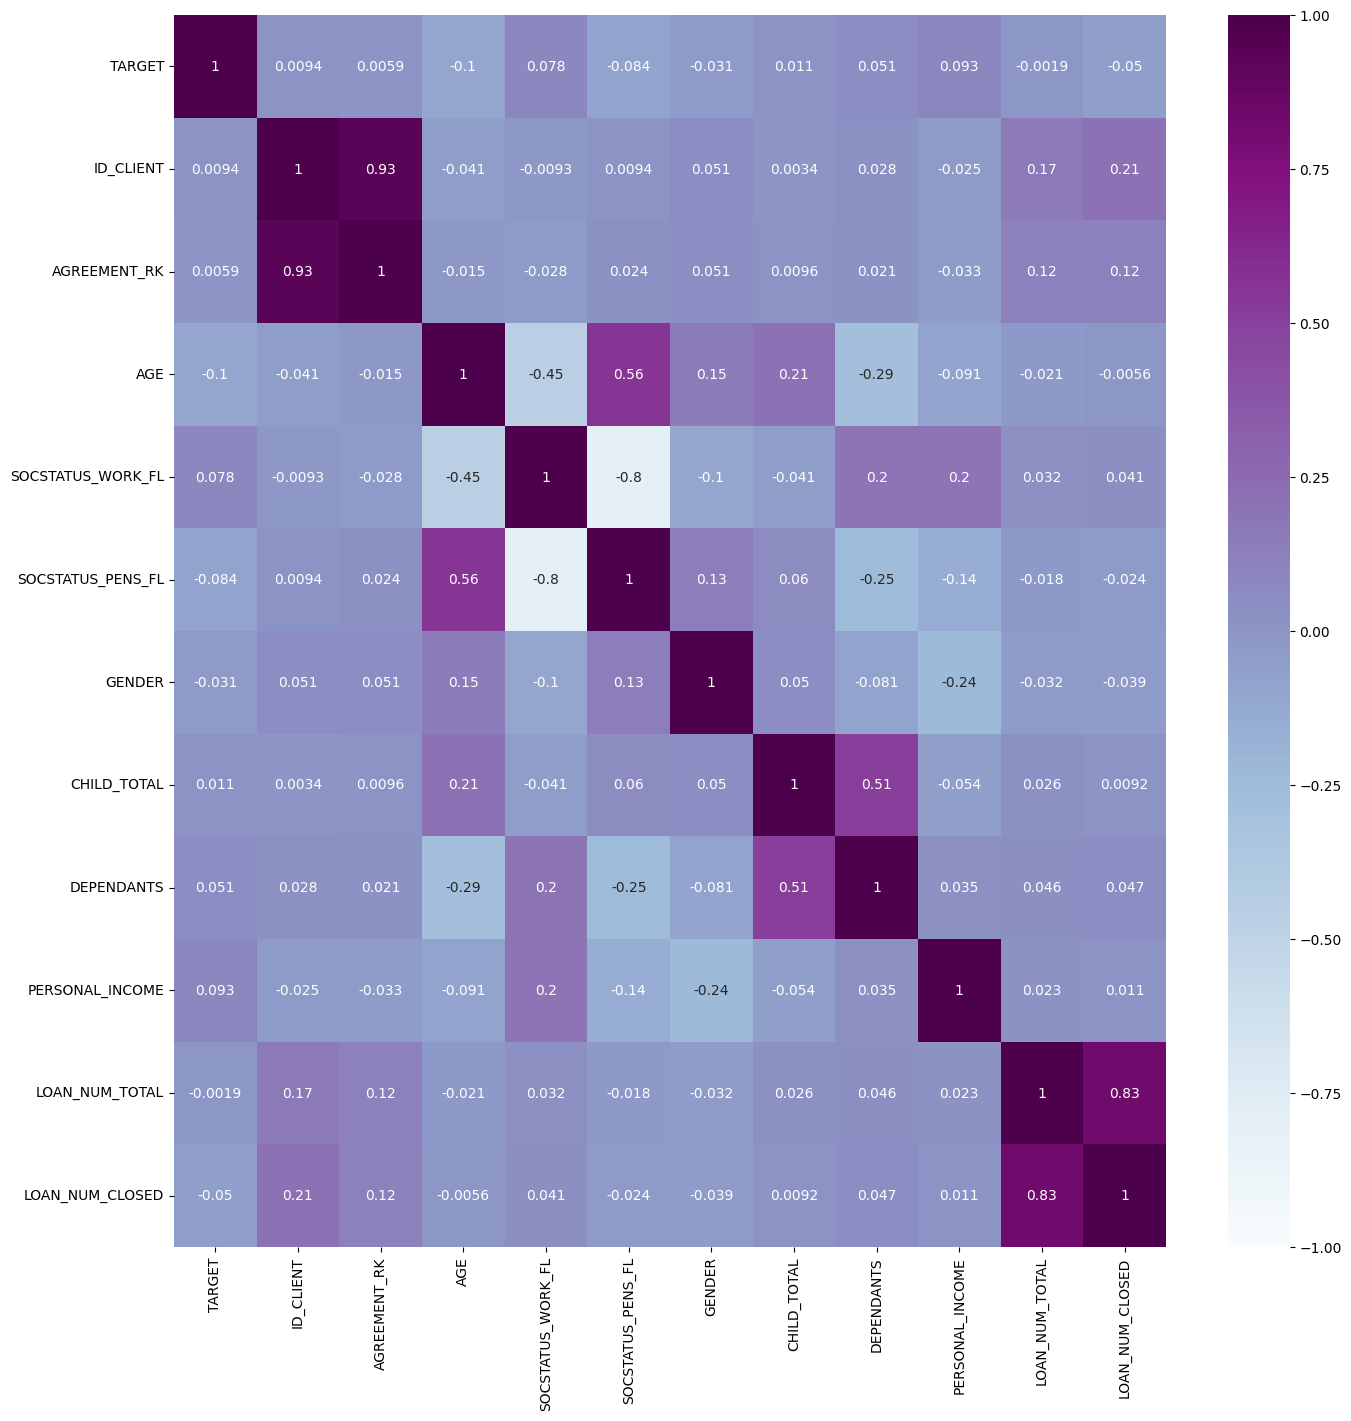

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 16)) 
sns.heatmap(df.corr(), cmap='BuPu', annot=True, vmin=-1, vmax=1)

## Задание 2

При помощи инструмента Streamlit проведите разведочный анализ данных. В него может входить:

* построение графиков распределений признаков
* построение матрицы корреляций
* построение графиков зависимостей целевой переменной и признаков
* вычисление числовых характеристик распределения числовых столбцов (среднее, min, max, медиана и так далее)
* любые другие ваши идеи приветствуются!

[Пример Streamlit-приложения](https://rateyourflight.streamlit.app) с разведочным анализом, прогнозом модели и оценкой ее результатов.